In [13]:
# ! pip install pyLDAvis

The core packages used in this tutorial are re, gensim, spacy and pyLDAvis. Besides this we will also using matplotlib, numpy and pandas for data handling and visualization. Let’s import them.

In [2]:
import nltk
from nltk import FreqDist
nltk.download('stopwords') # run this one time
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import numpy as np 
import re 
import spacy 
import gensim 
from gensim import corpora 
# libraries for visualization 
import pyLDAvis 
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
# Loading the Data

In [4]:
df = pd.read_csv('Short.csv',encoding= 'latin1') 

In [5]:
df.head(3)

,Case_Owner,Incident_Number,Teams,Chat Closed By,Geo,Response Time of Agent,Transaction Start Date,Transaction End Date,Chat Duration,Customer Rating,Transferred Chat,Customer Wait Time,Description,Resolution
0,Zaha,16021106,Mobile Service Team,Customer,EMER,0:01:02,6/8/2018 23:59,7/8/2018 0:18,0:18:22,9,False,0:02:01,Set up Skype for Business,Set up Skype for Business Online external communications
1,Berenice,16021107,Mobile Technical Team,Representative,APAC,0:00:00,6/8/2018 23:59,7/8/2018 0:02,0:03:05,7,True,0:01:01,Troubleshoot public folder,Troubleshoot public folder replication for Exchange Server
2,Madi,16021108,Mobile Service Team,Customer,APAC,0:00:32,6/8/2018 23:59,7/8/2018 0:26,0:22:33,4,False,0:01:01,Troubleshoot ActiveSync Server,Troubleshoot ActiveSync with Exchange Server


### Data Preprocessing
### Data preprocessing and cleaning is an important step before any text mining task, in this step, we will remove the punctuation, stopwords and normalize the reviews as much as possible

In [6]:
# function to plot most frequent terms 
def freq_words(x, terms = 10): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  
  fdist = FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()),   
             'count':list(fdist.values())}) 
  # selecting top 10 most frequent words 
  d = words_df.nlargest(columns="count", n = terms)      
  plt.figure(figsize=(30,7.5)) 
  ax = sns.barplot(data=d, x= "word", y = "count") 
  ax.set(ylabel = 'Count') 
  plt.show()

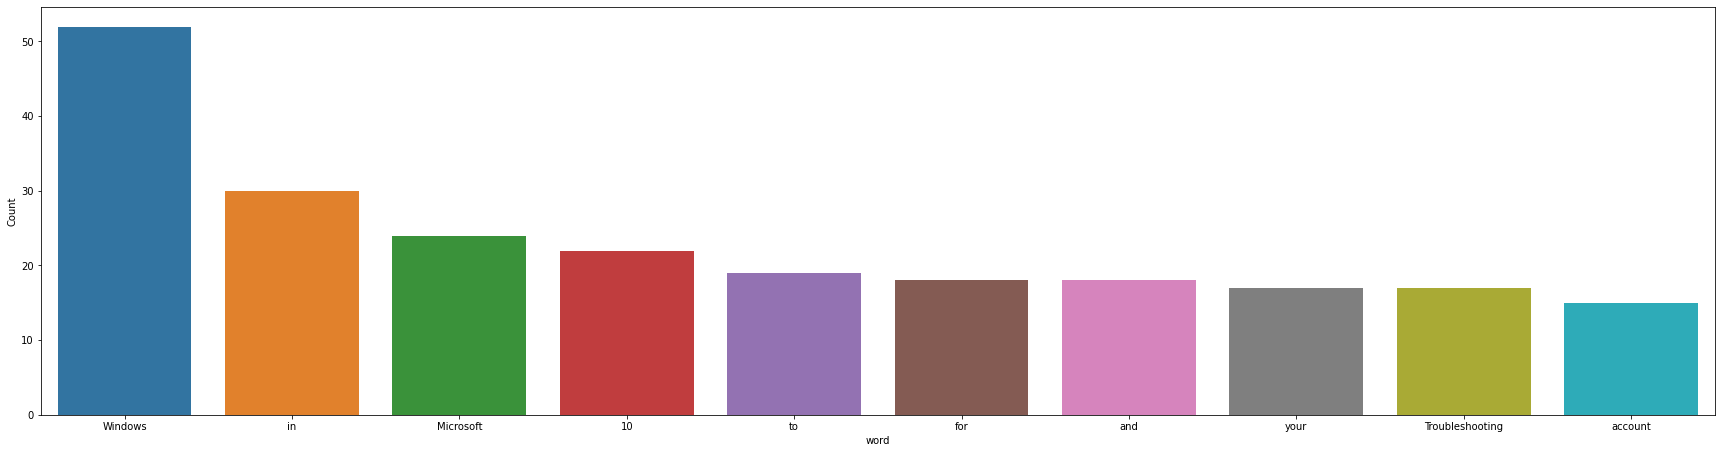

In [7]:
freq_words(df['Description'].astype(str))

In [8]:
# remove unwanted characters, numbers and symbols 
df['Description'] = df['Description'].str.replace("[^a-zA-Z#]", " ")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


The downloaded stopwords are imported

In [9]:
from nltk.corpus import stopwords 
stop_words = stopwords.words('english')

In [10]:
# function to remove stopwords 
def remove_stopwords(rev):     
  rev_new = " ".join([i for i in rev if i not in stop_words])      
  return rev_new 

In [11]:
# remove short words (length < 3) 
df['Description'] = df['Description'].astype(str).apply(lambda x: ' '.join([w for w in x.split() if len(w)>3])) 
# remove stopwords from the text 
Description = [remove_stopwords(r.split()) for r in df['Description']] 
# make entire text lowercase 
Description = [r.lower() for r in Description]

Top Words after removing the Stop Words

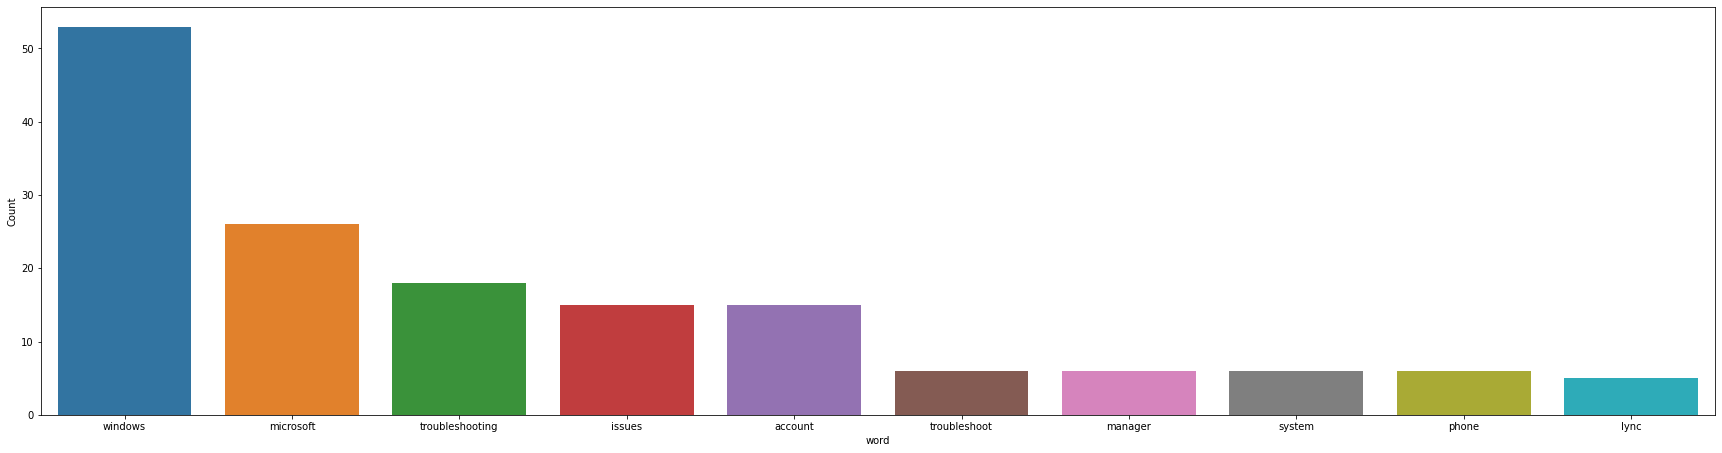

In [12]:
freq_words(Description, 10)

Tokenize  and then lemmatize the description and resolution

In [ ]:
!python -m spacy download en #one time run

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 4.9 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 

In [ ]:
def lemmatization(texts, tags=['NOUN', 'ADJ']): 
       output = []        
       for sent in texts:              
             doc = nlp(" ".join(sent))                             
             output.append([token.lemma_ for token in doc if 
             token.pos_ in tags])        
       return output

In [ ]:
tokenized_reviews_d = pd.Series(Description).apply(lambda x: x.split())
print(tokenized_reviews_d[1])

['troubleshoot', 'public', 'folder']


In [ ]:
reviews_2 = lemmatization(tokenized_reviews_d)

Top 10 words from the Documents

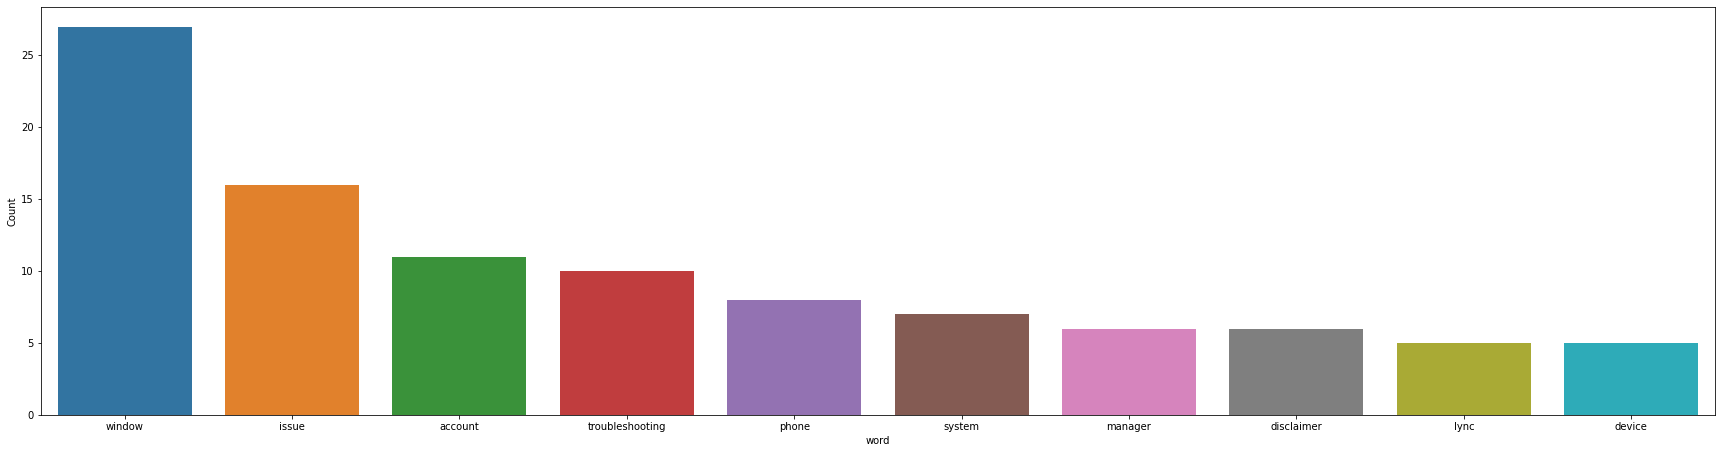

In [ ]:
reviews_4 = []
for i in range(len(reviews_2)):
  reviews_4.append(' '.join(reviews_2[i]))

df['Description'] = reviews_4

freq_words(df['Description'], 10)

In [ ]:
from pandas import DataFrame

In [ ]:
L_description = DataFrame (reviews_4, columns=['Case_Description'])

In [ ]:
L_description.head()

,Case_Description
0,business
1,public folder
2,server
3,mailbox
4,scheduling lync meeting


In [ ]:
# Model Building

In [ ]:
dictionary = corpora.Dictionary(reviews_2)

In [ ]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [ ]:
# Creating the object for LDA model using gensim library 
LDA = gensim.models.ldamodel.LdaModel 

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [ ]:
# Build LDA model 
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=3, random_state=100, chunksize=1000, passes=50)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [ ]:
lda_model.print_topics()

[(0,
  '0.045*"issue" + 0.044*"phone" + 0.034*"troubleshooting" + 0.034*"manager" + 0.023*"protection" + 0.022*"account" + 0.018*"agent" + 0.018*"operation" + 0.018*"software" + 0.018*"verification"'),
 (1,
  '0.091*"window" + 0.041*"account" + 0.035*"disclaimer" + 0.030*"lync" + 0.024*"business" + 0.018*"gift" + 0.018*"meeting" + 0.013*"device" + 0.013*"mobile" + 0.013*"troubleshoot"'),
 (2,
  '0.060*"window" + 0.034*"issue" + 0.024*"system" + 0.023*"requirement" + 0.023*"setting" + 0.023*"office" + 0.023*"troubleshooting" + 0.018*"outlook" + 0.018*"explorer" + 0.018*"device"')]

LDA model is built, the next step is to examine the produced topics and the associated keywords. Using pyLDAvis package’s interactive chart as is designed to work well with jupyter notebooks.

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, doc_term_matrix,  dictionary)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.138659  0.019869       1        1  34.646221
2      0.046481 -0.100365       2        1  33.467980
1      0.092178  0.080496       3        1  31.885798, topic_info=           Term       Freq      Total Category  logprob  loglift
49       window  18.000000  18.000000  Default  30.0000  30.0000
78        phone   6.000000   6.000000  Default  29.0000  29.0000
133  disclaimer   4.000000   4.000000  Default  28.0000  28.0000
17      manager   4.000000   4.000000  Default  27.0000  27.0000
70      account   7.000000   7.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
141        lock   0.887242   1.995498   Topic3  -4.8874   0.3325
166       space   0.880840   1.984524   Topic3  -4.8947   0.3308
145        safe   0.877075   1.984611   Topic3  -4.8990   0.3264
163       group   0.869022   1.984807   Topic3  -4.9082   0.3171
73      website   0.868522   1.996283   Topic3  -4.9087   0.3108

[157 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
70        1  0.377902   account
70        3  0.629837   account
127       2  0.750146    action
174       2  0.750145  activity
153       1  0.743740   address
...     ...       ...       ...
73        3  0.500931   website
49        2  0.379809    window
49        3  0.596843    window
53        1  0.743739      wsus
77        3  0.758955      xbox

[152 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews_2, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for


Perplexity:  -5.102740136267116

Coherence Score:  0.6585871562354918


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=reviews_2, start=2, limit=10, step=1)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

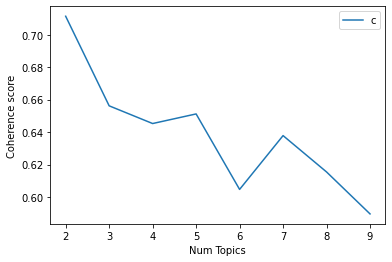

In [ ]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7114
Num Topics = 3  has Coherence Value of 0.6562
Num Topics = 4  has Coherence Value of 0.6453
Num Topics = 5  has Coherence Value of 0.6512
Num Topics = 6  has Coherence Value of 0.6047
Num Topics = 7  has Coherence Value of 0.6378
Num Topics = 8  has Coherence Value of 0.6154
Num Topics = 9  has Coherence Value of 0.5896
